In [11]:
import pandas as pd
from utils import pca_utils, utils, pca_utils, plots
import numpy as np

In [334]:
def del_col_max_lt_value(df, value=20):
    for c in df:
        if df[c].max() < value:
            del df[c]

def del_col_percentile_lt_value(df, value=3):
    for c in df:
        if np.percentile(df[c], 75) < value:
            del df[c]

# Abrir arquivos

In [ ]:
df_props = pd.read_csv('./output/df_props')
df_authors = pd.read_csv('./output/df_authors')
df_topics = pd.read_csv('./output/df_topics')

## Get entities

# 1) Dimensão Autoria

In [179]:
df_authors = pd.DataFrame(props_authors)
df_authors["id_dep"] = df_authors["uri"].apply(
    lambda x: int(x.split("/")[-1]) if x.split("/")[-1] else 0
)

In [332]:
df_authors_generic = (
    df_authors[["id_prop", "id_dep"]]
    .join(pd.get_dummies(df_props["siglaTipo"]))
    .loc[:, "id_dep":]
    .groupby("id_dep")
    .sum()
    .reset_index()
)
df_authors['id_prop'] = df_authors['id_prop'].astype(int)

df_authors_generic.set_index('id_dep', inplace=True)

df_authors_generic = df_authors_generic.astype(int)

del_col_percentile_lt_value(df_authors_generic, value=3)

In [333]:
df_authors_generic

,DOC,EMC,EMP,INC,PAR,PDL,PL,PRL,RDF,REQ,RIC,RPD,SBT
id_dep,,,,,,,,,,,,,
0,38,113,11,87,39,25,166,179,17,288,67,189,22
4,1,9,2,6,0,0,7,2,0,8,3,5,0
57,0,0,0,0,1,1,0,0,0,0,0,0,0
60,0,2,0,2,2,0,5,5,1,7,0,2,1
78,7,26,3,21,13,8,42,51,9,40,31,47,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
539635,0,0,0,0,0,0,0,0,0,0,0,0,0
539638,0,0,0,0,0,0,0,0,0,0,0,0,0
539655,0,0,0,0,0,0,0,0,0,0,0,0,0


### PCA

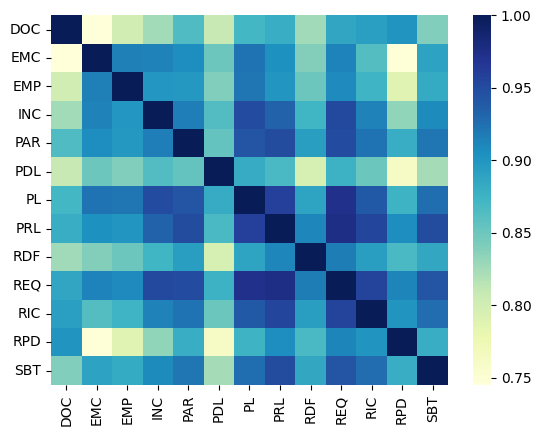

In [335]:
plots.plotar_matriz_corr(df_authors_generic)

In [293]:
X = np.matrix(df_authors_generic).astype(float)
X_LOG = np.asarray(np.log(X +1 ))

S = np.cov(np.transpose(X))

X = np.asarray(X)

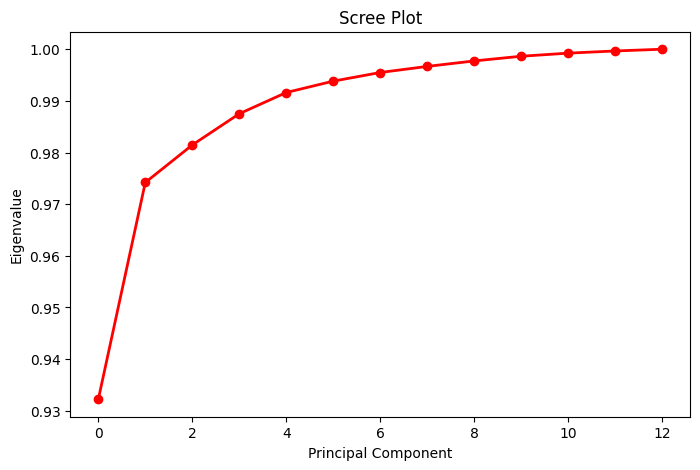

In [295]:
pca, df_pca = pca_utils.calcular_pca(X, n_components=len(X[0]))
plots.plotar_scree_plot(pca.explained_variance_ratio_)

In [310]:
pca, df_pca = pca_utils.calcular_pca(X, n_components=2)
df_pca.set_index(df_authors_generic.index, inplace=True)

df_pca_autoria = df_pca.copy()

df_pca_autoria.columns = [f"PCA_TIPO_{c}" for c in df_pca_autoria.columns]

### Cargas vetoriais

In [ ]:
df_cargas = pd.DataFrame()
df_cargas["tipos"] = df_authors_generic.columns

prefix = "PCA_TIPOS_"
df_cargas = pca_utils.calcular_cargas_fatoriais(pca, df_cargas, prefix=prefix)
# df_cargas = calcular_cargas_fatoriais(pca, df_cargas, prefix=prefix)

df_cargas.sort_values(f'{prefix}7', ascending=False).head(20)

# 2) Dimensão Temas

In [269]:
df_topics = pd.DataFrame(props_topics)
df_topics = df_topics.join(pd.get_dummies(df_topics["tema"]))
df_topics = df_topics.loc[:, "id_prop":]

df_topics['id_prop'] = df_topics['id_prop'].apply(lambda x: int(x))

df_authors_topic = (
    df_authors[["id_prop", "id_dep"]]
    .merge(df_topics)
    .loc[:, "id_dep":]
    .groupby("id_dep")
    .sum()
    .reset_index()
)

df_authors_topic.set_index('id_dep', inplace=True)


df_authors_topic.describe().T

,count,mean,std,min,25%,50%,75%,max
Administração Pública,1015.0,18.408867,36.549058,0.0,2.0,7.0,18.0,602.0
"Agricultura, Pecuária, Pesca e Extrativismo",1015.0,4.039409,27.528225,0.0,0.0,1.0,3.0,838.0
"Arte, Cultura e Religião",1015.0,2.776355,6.051247,0.0,0.0,1.0,3.0,103.0
Cidades e Desenvolvimento Urbano,1015.0,2.372414,8.051806,0.0,0.0,1.0,2.0,170.0
"Ciência, Tecnologia e Inovação",1015.0,1.893596,8.457954,0.0,0.0,0.0,2.0,211.0
Ciências Exatas e da Terra,1015.0,0.004926,0.070048,0.0,0.0,0.0,0.0,1.0
Ciências Sociais e Humanas,1015.0,0.008867,0.093793,0.0,0.0,0.0,0.0,1.0
Comunicações,1015.0,4.422660,37.208031,0.0,0.0,1.0,3.0,1045.0
Defesa e Segurança,1015.0,9.748768,17.449305,0.0,1.0,4.0,11.0,214.0
Direito Civil e Processual Civil,1015.0,2.026601,5.469684,0.0,0.0,1.0,2.0,120.0


In [275]:
# del_col_max_lt_value(df_authors_topic)
del_col_percentile_lt_value(df_authors_topic, value=4)

In [277]:
df_authors_topic.describe().T

,count,mean,std,min,25%,50%,75%,max
Administração Pública,1015.0,18.408867,36.549058,0.0,2.0,7.0,18.0,602.0
Defesa e Segurança,1015.0,9.748768,17.449305,0.0,1.0,4.0,11.0,214.0
Direito Penal e Processual Penal,1015.0,5.368473,8.493540,0.0,0.0,2.0,7.0,78.0
Direito e Defesa do Consumidor,1015.0,3.188177,4.640217,0.0,0.0,2.0,4.0,48.0
Direitos Humanos e Minorias,1015.0,18.473892,31.907303,0.0,2.0,7.0,21.0,276.0
Economia,1015.0,5.086700,16.273560,0.0,0.0,2.0,5.0,420.0
Educação,1015.0,8.431527,22.010464,0.0,0.0,2.0,8.0,402.0
Finanças Públicas e Orçamento,1015.0,15.873892,24.504877,0.0,3.0,9.0,19.0,339.0
"Indústria, Comércio e Serviços",1015.0,4.761576,7.357073,0.0,0.5,2.0,6.0,105.0
Meio Ambiente e Desenvolvimento Sustentável,1015.0,5.322167,15.077239,0.0,0.0,1.0,5.0,189.0


## PCA

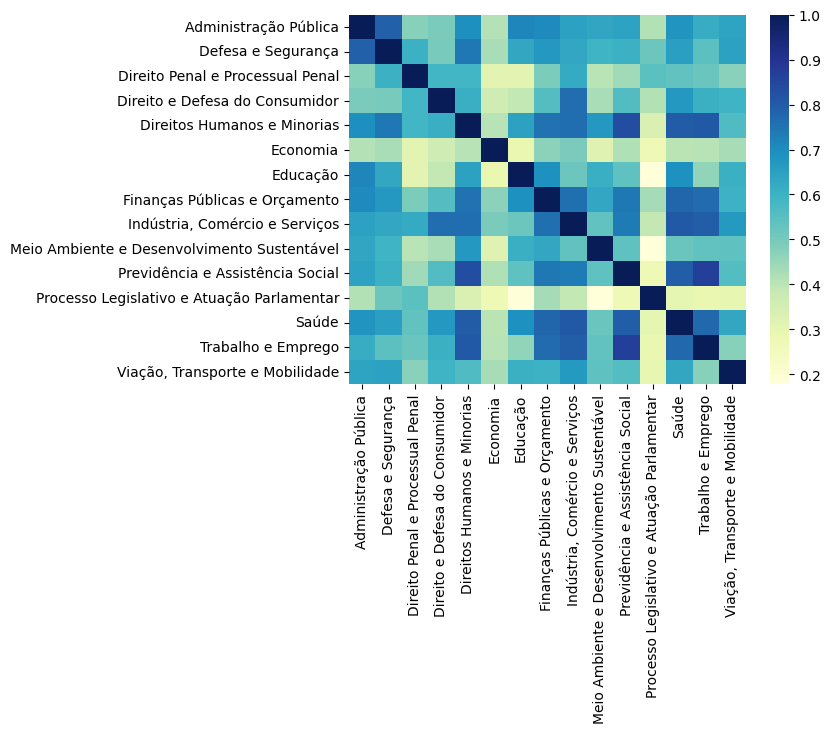

In [278]:
plots.plotar_matriz_corr(df_authors_topic)

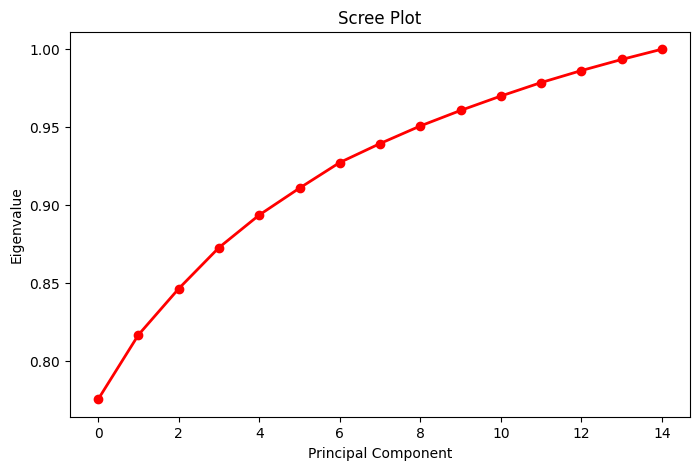

In [282]:

X = np.matrix(df_authors_topic)

S = np.cov(np.transpose(X))

X_LOG = np.asarray(np.log(X +1 ))
X = np.asarray(X)

# # variâncias

# np.diagonal(S)

## stree_plot 

pca, df_pca = pca_utils.calcular_pca(X_LOG, n_components=len(df_authors_topic.columns))
plots.plotar_scree_plot(pca.explained_variance_ratio_)

pca, df_pca = pca_utils.calcular_pca(X_LOG, n_components=4)
# df_pca.columns = [[f'PCA_TEMA_{i}' for i in range(0, 5) ]]
df_pca.set_index(df_authors_topic.index, inplace=True)

df_pca_tema = df_pca.copy()

df_pca_tema.columns = [f"PCA_TEMA_{c}" for c in df_pca_tema.columns]

### Cargas vetoriais

In [ ]:
# entender cargas

df_cargas = pd.DataFrame()
df_cargas["temas"] = df_pca_tema.columns[:NUM_OF_TOPICS]

prefix = "PCA_TEMAS_"
df_cargas = pca_utils.calcular_cargas_fatoriais(pca, df_cargas, prefix=prefix)

ValueError: Length of values (22) does not match length of index (5)

## Calcular concentração temática

## Calcular se é alta ou baixa concentração

# Deputados

In [124]:
deputados = utils.open_json("D:/ARTIGO_ABCP/data", "deputados.json")

df_deps = pd.DataFrame(deputados)

# Merge

In [298]:
ids_deps = df_deps["id"].unique()

df = pd.DataFrame()
df["id_dep"] = ids_deps

df.set_index('id_dep', inplace=True)

df_pca_final = df.join(df_pca_tema, how='inner').join(df_pca_autoria, how='inner').dropna()

# Análise

In [301]:
from utils import plots
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

In [302]:
def melt_df(df, val_columns, cluster_column="Cluster"):
    # Melt the DataFrame
    df_melted = df.reset_index().melt(
        id_vars=["id_dep", cluster_column],  # Keep these as identifier columns
        value_vars=val_columns,
        var_name="var",
        value_name="value",
    )

    df_melted["value"] = df_melted["value"].astype(float)

    return df_melted


def plot_melted_df(df_melted, hue_col="Cluster", figsize=(12, 8), xticks_rotation=45):
    # Set the desired figure size (width, height) in inches
    plt.figure(figsize=figsize)

    # Create the Seaborn boxplot
    sns.boxplot(data=df_melted, x="var", y="value", hue=hue_col)

    # Optional: Adjust layout for better readability (especially with many boxes)
    plt.xticks(rotation=xticks_rotation, ha="right")  # Rotate x-axis labels if needed

    # Show the plot
    plt.tight_layout()
    plt.show()


def cluster_dataframe(
    df,
    techniques=["kmeans", "dbscan", "gmm"],
    k_value=3,
    eps=0.5,
    min_samples=5,
):
    """
    Clusters the input DataFrame using k-means, DBSCAN, and GMM algorithms.

    Args:
        df (pd.DataFrame): The DataFrame to be clustered.
        k_value (int, optional): Number of clusters for k-means. Defaults to 3.
        eps (float, optional): Maximum distance between two samples for DBSCAN. Defaults to 0.5.
        min_samples (int, optional): Minimum number of samples in a neighborhood for DBSCAN. Defaults to 5.

    Returns:
        pd.DataFrame: The original DataFrame with added columns for cluster labels from each algorithm.
    """

    # K-means
    if 'kmeans' in techniques:
        kmeans = KMeans(n_clusters=k_value, random_state=0).fit(df)
        df["k_means_cluster"] = kmeans.labels_

    # DBSCAN
    if 'dbscan' in techniques:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples).fit(df)
        df["dbscan_cluster"] = dbscan.labels_

    # Gaussian Mixture Model (GMM)
    if 'gmm' in techniques:
        gmm = GaussianMixture(n_components=k_value, random_state=0).fit(df)
        df["gmm_cluster"] = gmm.predict(df)

    return df

## Com PCA

Parameter: {'n_clusters': 2} Score 0.7312135935807205
Parameter: {'n_clusters': 3} Score 0.7089547132017762
Parameter: {'n_clusters': 4} Score 0.7172528123778331
Parameter: {'n_clusters': 5} Score 0.7226839859265317
Parameter: {'n_clusters': 6} Score 0.709493768162242
Parameter: {'n_clusters': 7} Score 0.7104783651465189
Parameter: {'n_clusters': 8} Score 0.702761522964993
Parameter: {'n_clusters': 16} Score 0.6830560961071982
Parameter: {'n_clusters': 32} Score 0.6669175330272733
Parameter: {'n_clusters': 64} Score 0.6589494188380591
Parameter: {'n_clusters': 80} Score 0.630514385408778


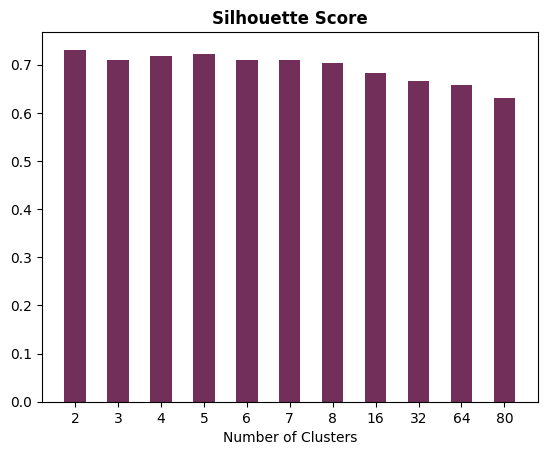

In [315]:
# df_cluster = df_pca_final.copy()
df_cluster = df_pca_autoria.copy()

# del df_cluster['PCA_TEMA_0']
# del df_cluster['PCA_TIPO_0']

parameters = [2, 3, 4, 5, 6, 7, 8, 16, 32, 64, 80]

plots.plot_silhouette_score(df_cluster, parameters)

In [316]:
pca_columns = df_cluster.filter(like='PCA_').columns  # Select columns containing 'PCA'

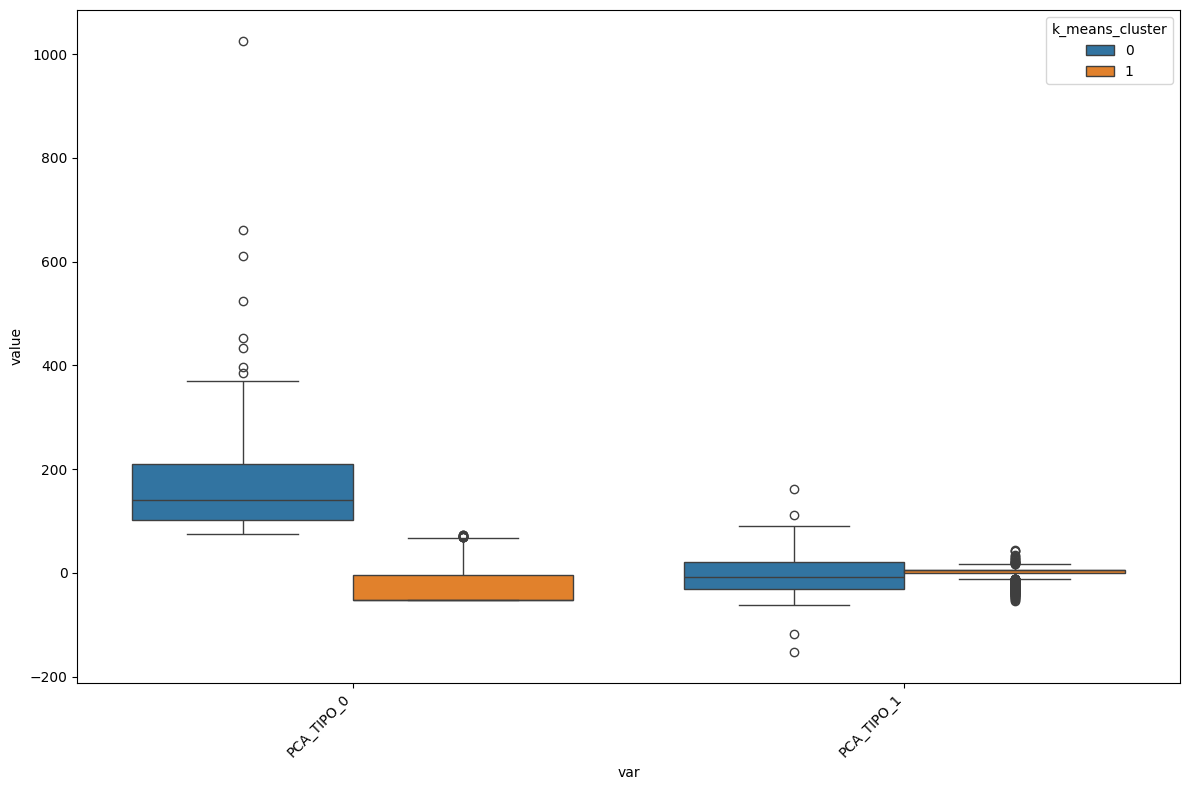

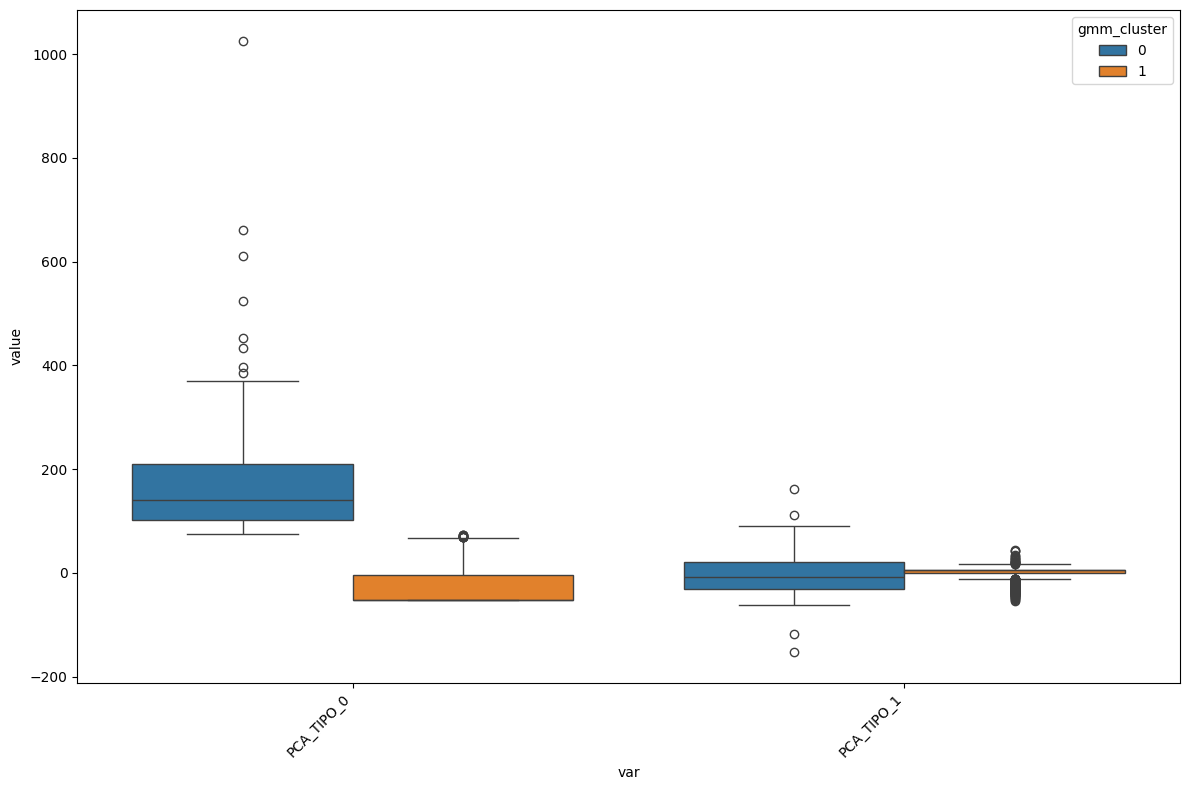

In [317]:
df = df_cluster.copy()
df_clusters = cluster_dataframe(df, k_value=2)

cols = ["k_means_cluster",  "gmm_cluster"] #"dbscan_cluster",
for col in cols:
    df_c_melted = melt_df(df_clusters, val_columns=pca_columns, cluster_column=col)
    plot_melted_df(df_c_melted, hue_col=col)

# Sem PCA

In [320]:
df_sem_pca = df_authors_topic.join(df_authors_generic, how='inner')

In [329]:
df_sem_pca_log = np.log(df_authors_topic + 1)

In [330]:
df_c_sem_pca = cluster_dataframe(df_sem_pca_log, techniques=['kmeans'])

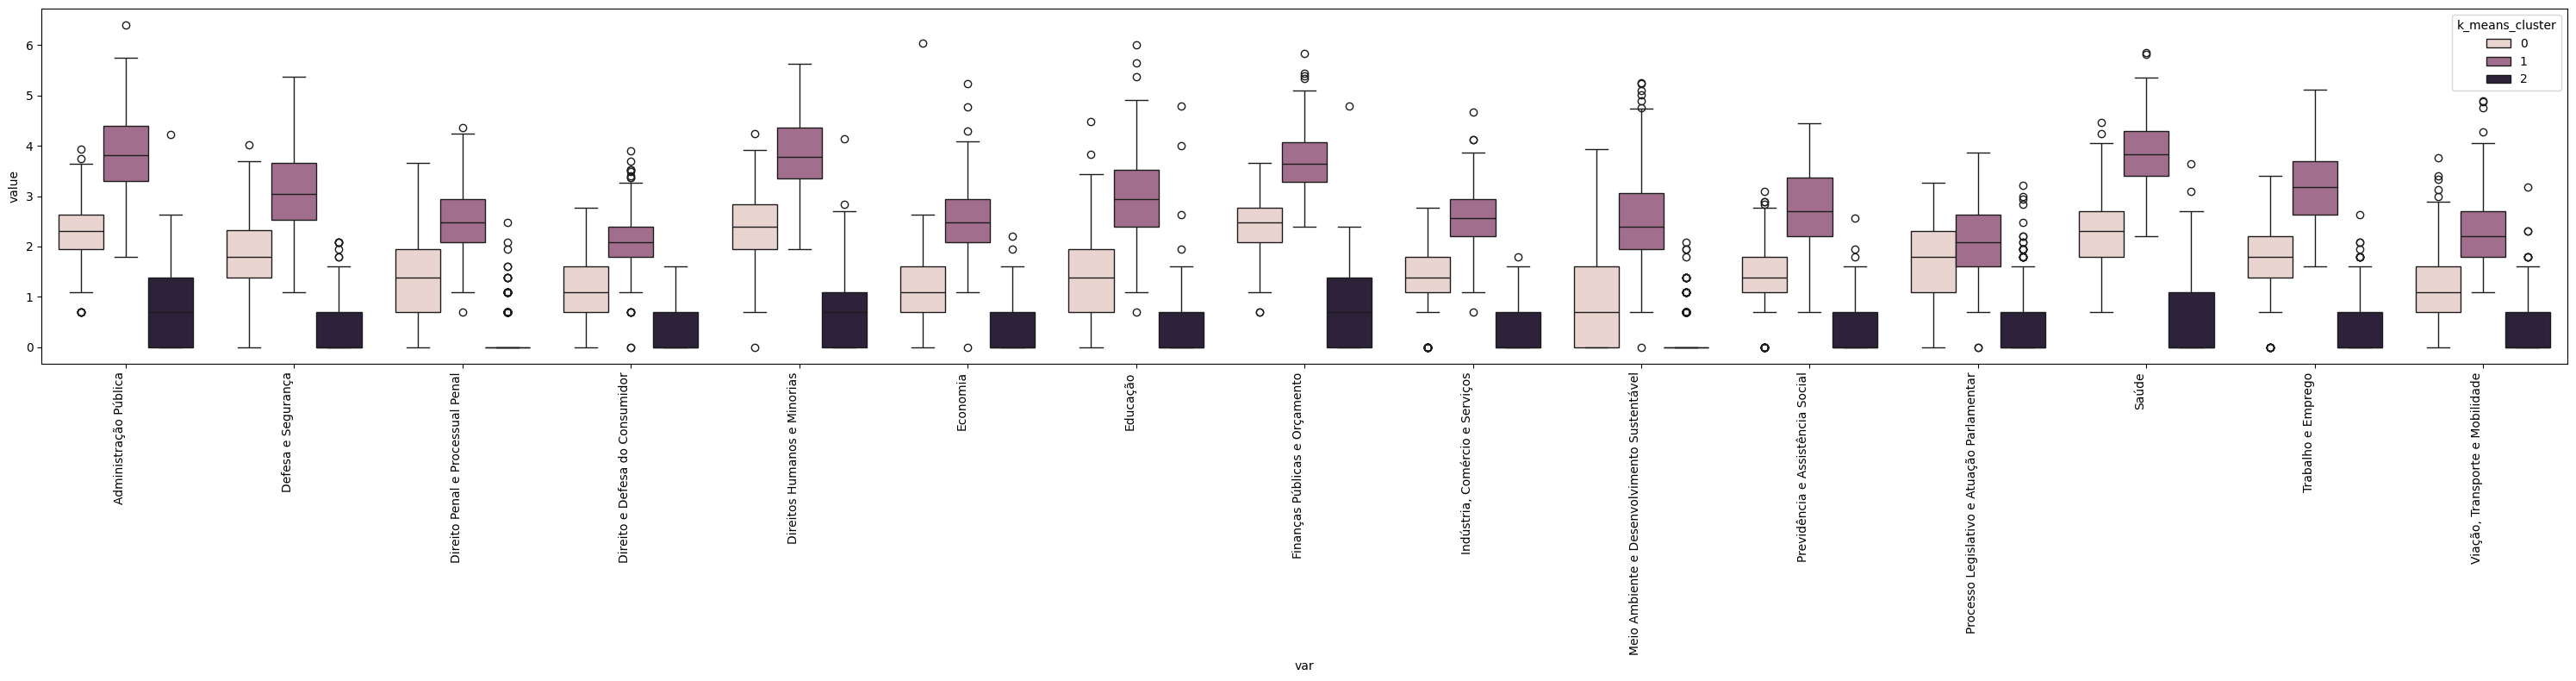

In [331]:
cols = ["k_means_cluster"] #'gmm_cluster',"dbscan_cluster",
for col in cols:
    df_c_melted = melt_df(df_c_sem_pca, val_columns=df_authors_topic.columns, cluster_column=col)
    plot_melted_df(df_c_melted, hue_col=col, figsize=(30,8), xticks_rotation=90)